# Import of necessary libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle #Used in localization of defects

# Reading Images

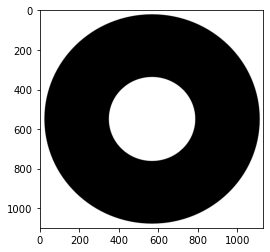

In [26]:
img = cv2.imread("/kaggle/input/circle-detection/nondefective/good.png")
plt.imshow(img)

# Applying Image Transformations

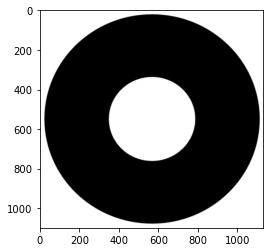

In [27]:
# Apply Gaussian blur to the image to remove noise
blurred = cv2.GaussianBlur(img, (5, 5), 0)
plt.imshow(blurred)

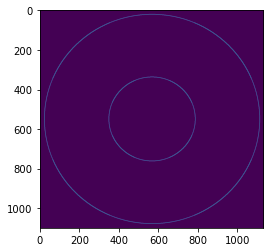

In [28]:
# Setting All parameters
t_lower = 100  # Lower Threshold
t_upper = 200  # Upper threshold
aperture_size = 5  # Aperture size
  
# Applying the Canny Edge filter
edge = cv2.Canny(blurred, t_lower, t_upper, apertureSize=aperture_size)
edge_copy = edge.copy()
plt.imshow(edge_copy)

# Contour Detection

In [29]:
# Find contours in the image
contours, _ = cv2.findContours(edge_copy, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 

#cv2.RETR_TREE - Retrieves contours in tree hierarchy
#cv2.CHAIN_APPROX_NONE - All contour points are stored

# Defect Detection and Localization

In [30]:
area_ratio_appended = []
Defective = False;

for i in [0, 3]: #Extracting the outer and inner ring
    contour = contours[i]
    ellipse = cv2.fitEllipse(contour)
    (x, y), (MA, ma), angle = ellipse

    # Create a mask for the filled contour and filled ellipse
    contour_black = np.zeros(img.shape, np.uint8)
    contour_mask = cv2.drawContours(contour_black, [contour], 0, (255,255,255), -1) # -1 indicates filling
    
    ellipse_black = np.zeros(img.shape, np.uint8)
    ellipse_mask = cv2.ellipse(ellipse_black, ellipse, (255,255,255), -1)

    # Bitwise XOR the two masks to get the intersection
    intersection_mask = cv2.bitwise_xor(contour_mask, ellipse_mask)
      
    # Taking a matrix of size 5 as the kernel
    kernel = np.ones((5, 5), np.uint8)
    intersection = cv2.morphologyEx(intersection_mask, cv2.MORPH_OPEN, kernel) #cv2.morphologyEx - Erosion followed by dilation
    intersection_single_channel = cv2.cvtColor(intersection, cv2.COLOR_BGR2GRAY) #Needed for counting white pixels
    
    actual_area = cv2.bitwise_xor(intersection, ellipse_mask)
    actual_area_single_channel = cv2.cvtColor(actual_area, cv2.COLOR_BGR2GRAY) 
    
    ellipse_mask_single_channel = cv2.cvtColor(ellipse_mask, cv2.COLOR_BGR2GRAY)  
    
    num_white_pixels_area = cv2.countNonZero(actual_area_single_channel)
    num_white_pixels_ellipse = cv2.countNonZero(ellipse_mask_single_channel)
    
    area_ratio = num_white_pixels_area/num_white_pixels_ellipse
    area_ratio_appended.append(area_ratio)
    
    num_white_pixels = cv2.countNonZero(intersection_single_channel)
    
    if num_white_pixels > 0: #Indicating a defect  
        intersection_edge = cv2.Canny(intersection_single_channel, 100, 200, 5)
        intersection_edge_copy = intersection_edge.copy()

        # Find contours in the image
        intersection_contours, _ = cv2.findContours(intersection_edge_copy, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        intersection_contour = intersection_contours[0]
        (x, y), radius = cv2.minEnclosingCircle(intersection_contour) #Localizing the defect
        
        # Plotting
        plt.figure(figsize=(10,10))
        plt.imshow(img, cmap='gray')
        plt.title('Original Image with highlighted Defect')
        
        #Intersection display 
        plt.imshow(cv2.drawContours(255*np.ones_like(intersection_single_channel), intersection_contours, 0, 0, 1), cmap='gray_r', alpha=0.5)
        circ = Circle(xy=(x, y), radius=radius, color='red', fill=False, lw=2)
        plt.gca().add_artist(circ)

        Defective = True
        
print('Defective:', Defective)

# Classification of defect
def determine_defect(area_ratio_appended):
    if area_ratio_appended[0] < 1:
        return "Cut"
    elif area_ratio_appended[0] > 1:
        return "Flash"
    elif area_ratio_appended[1] < 1:
        return "Flash"
    elif area_ratio_appended[1] > 1:
        return "Cut"
    else:
        return

print(determine_defect(area_ratio_appended))

Defective: False
None


# Other defects
**Defect 1**

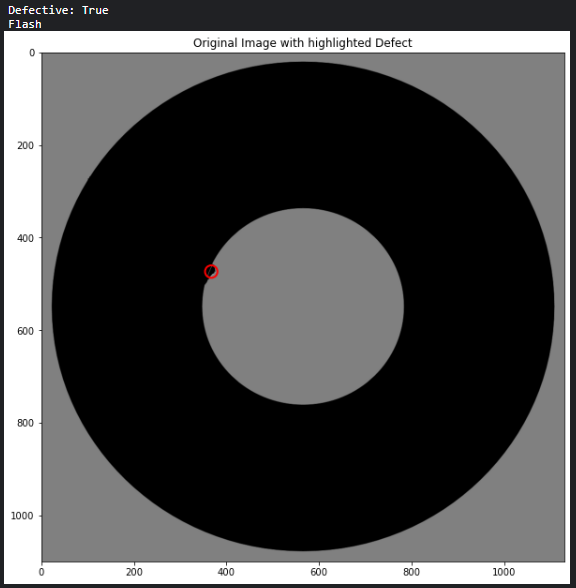

**Defect 2**

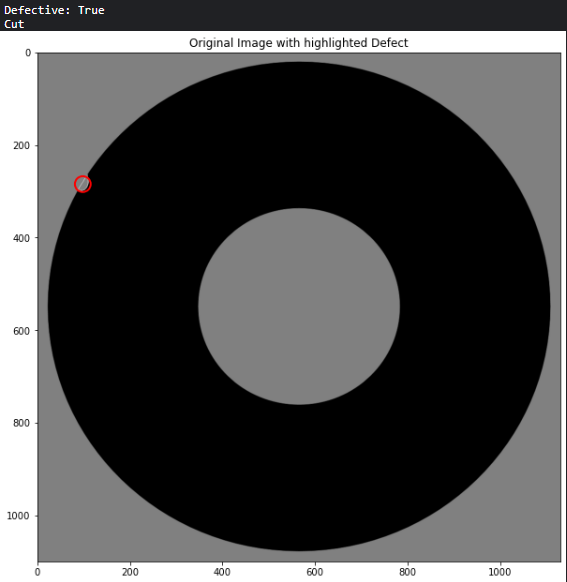

**Defect 3**

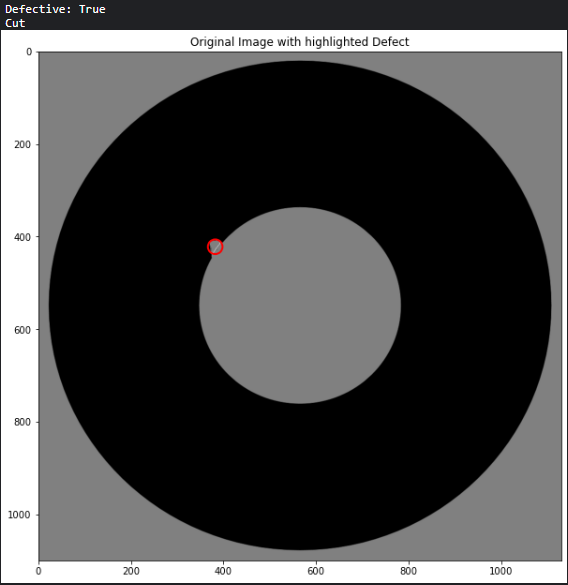

**Defect 4**

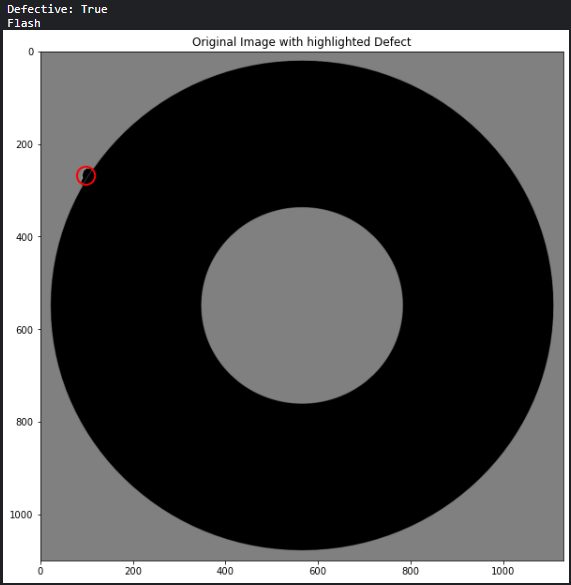